
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Selection of representative cases of multivariate wave conditions to simulate with SWAN
### Maximum Dissimilarity Algorithm (MDA)

inputs required: 
  * Historical waves
  * Emulator output - wave conditions

in this notebook:
  * Split sea and swell components
  * MDA selection of representative number of events


### Workflow:

<div>
<img src="../resources/nb02_01.png" width="400px">
</div>


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.mda import MaxDiss_Simplified_NoThreshold, nearest_indexes

from teslakit.plotting.mda import Plot_MDA_Data



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_emulator')


# Climate Emulator DWTs-WVS simulations
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

WVS_sim_upd = CE.LoadSim_All(TCs=True)


#----------------------------------------------------------
# Poner NaN en WVS_upd donde Hs, Tp y Dir de Swell_1 y Swell_2 valen 0 (Hubo TC y sólo tenemos Sea family)
vars = {'swell_1_Hs','swell_1_Tp','swell_1_Dir','swell_2_Hs','swell_2_Tp','swell_2_Dir'}
for var in vars:
    WVS_sim_upd[var] = WVS_sim_upd[var].where(WVS_sim_upd[var]!=0.00, np.nan)
    
print(WVS_sim_upd)


          DWT    sea_Hs     sea_Tp     sea_Dir  swell_1_Hs  swell_1_Tp  \
0        28.0  1.558233   7.720595   54.236469    0.847680    8.847652   
1         1.0  2.434917   8.870701   70.633003    0.868273    6.949690   
2        32.0  2.042879   8.130988  193.825287    0.070134   10.512196   
3        33.0  2.187252   9.949992   45.089931    0.898082    8.097234   
4        41.0  2.175673   8.794095   64.856918    0.452799   12.276597   
...       ...       ...        ...         ...         ...         ...   
1032639  28.0  1.104727   8.946943   56.569431    0.799593    9.060400   
1032640  13.0  1.527949   7.223116   80.367065    1.054351    8.853899   
1032641  28.0  2.542433  11.808179   29.937855    0.275985   11.897964   
1032642  20.0  1.810582   8.210051   56.327915    0.311176    9.856896   
1032643  20.0  2.255051   6.665843   67.612114    0.423456   11.085974   

         swell_1_Dir  swell_2_Hs  swell_2_Tp  swell_2_Dir        mu       tau  \
0          68.403099    0.3523

## Prepare Sea and Swells data

In [3]:
def split_sea_swells(WVS):
    '''
    splits WVS dataframe data into sea waves & swell waves dataframes
    
    requires WVS to contain variables with these names:
        'sea_Hs', 'sea_Tp', 'sea_Dir'
        'swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir'
        'swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir'
        ...
    
    '''
    
    # store n_sim if found in WVS dataset
    vns_extra = []
    if 'n_sim' in list(WVS.columns):
        vns_extra.append('n_sim') 

    
    # Prepare SEA waves
    vns_sea = ['sea_Hs', 'sea_Tp', 'sea_Dir'] + vns_extra
    
    wvs_sea = WVS[vns_sea]
    wvs_sea.dropna(inplace=True)  # clean nans
    wvs_sea.rename(columns={"sea_Hs":"hs", "sea_Tp":"tp", "sea_Dir": "dir"}, inplace=True)  # rename columns
    wvs_sea = wvs_sea[wvs_sea["dir"]<=360]  # filter data
    
    # Prepare SWELL_1 waves
    vns_swell_1 = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir'] + vns_extra

    wvs_swell_1 = WVS[vns_swell_1]
    wvs_swell_1.dropna(inplace=True)
    wvs_swell_1.rename(columns={"swell_1_Hs":"hs", "swell_1_Tp":"tp", "swell_1_Dir": "dir"}, inplace=True)
    wvs_swell_1 = wvs_swell_1[wvs_swell_1["dir"]<=360]  

    # Prepare SWELL_2 waves
    vns_swell_2 = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir'] + vns_extra

    wvs_swell_2 = WVS[vns_swell_2]
    wvs_swell_2.dropna(inplace=True)
    wvs_swell_2.rename(columns={"swell_2_Hs":"hs", "swell_2_Tp":"tp", "swell_2_Dir": "dir"}, inplace=True)
    wvs_swell_2 = wvs_swell_2[wvs_swell_2["dir"]<=360]  


    # join swell data
    wvs_swell = pd.concat([wvs_swell_1, wvs_swell_2], ignore_index=True)
    
    return wvs_sea, wvs_swell


In [4]:
# --------------------------------------
# split simulated waves data by family

wvs_sea_sim, wvs_swl_sim = split_sea_swells(WVS_sim_upd)

print(wvs_sea_sim)
print(wvs_swl_sim)


               hs         tp         dir  n_sim
0        1.558233   7.720595   54.236469      0
1        2.434917   8.870701   70.633003      0
2        2.042879   8.130988  193.825287      0
3        2.187252   9.949992   45.089931      0
4        2.175673   8.794095   64.856918      0
...           ...        ...         ...    ...
1032639  1.104727   8.946943   56.569431      9
1032640  1.527949   7.223116   80.367065      9
1032641  2.542433  11.808179   29.937855      9
1032642  1.810582   8.210051   56.327915      9
1032643  2.255051   6.665843   67.612114      9

[1032644 rows x 4 columns]
               hs         tp         dir  n_sim
0        0.847680   8.847652   68.403099      0
1        0.868273   6.949690   97.406113      0
2        0.070134  10.512196   45.761650      0
3        0.898082   8.097234   72.963425      0
4        0.452799  12.276597   83.315613      0
...           ...        ...         ...    ...
2042065  0.452487  11.575167  186.107849      9
2042066  0.3


## MaxDiss Classification

### Sea

In [5]:

# --------------------------------------
# Set MDA parameters

# variables to use
vns = ['hs','tp', 'dir']

# subset size, scalar and directional indexes
n_subset = 500            # subset size
ix_scalar = [0,1]           # tp
ix_directional = [2]      # dir



MaxDiss waves parameters: 1032644 --> 500

   MDA centroids: 500/500



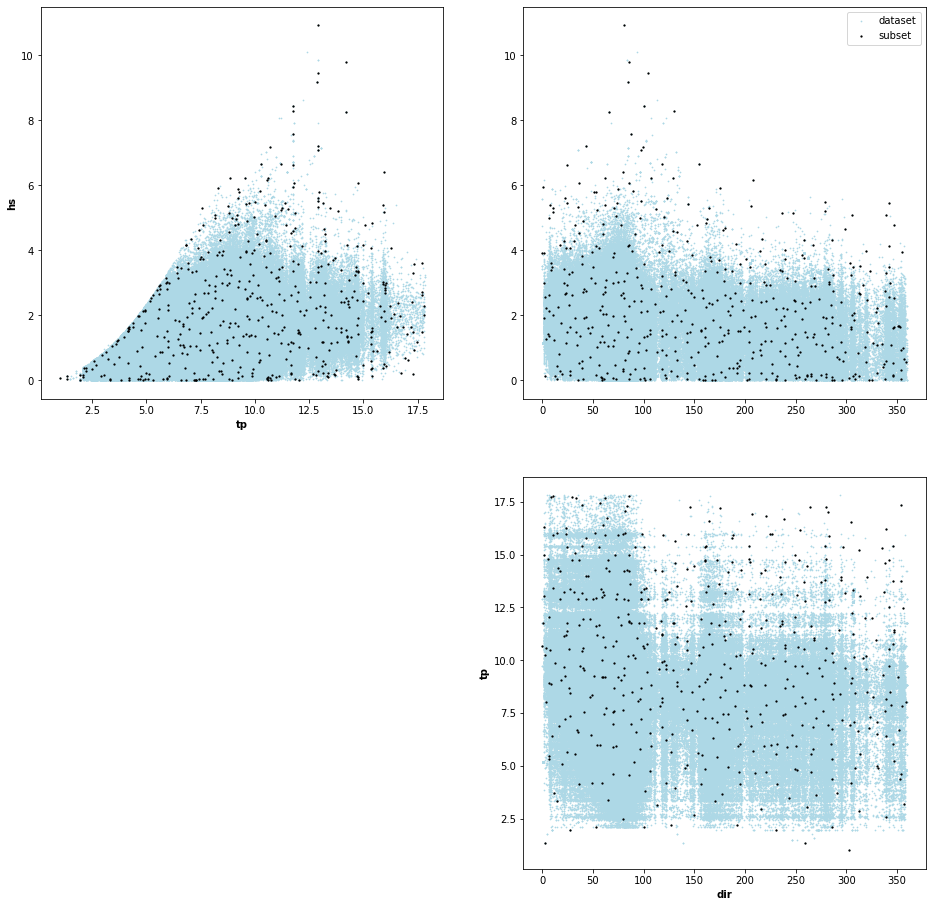

In [6]:
# --------------------------------------
# Sea
data = wvs_sea_sim[vns].values[:] 

# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(data, n_subset, ix_scalar, ix_directional)
wvs_sea_sim_subset = pd.DataFrame(data=sel, columns=vns)

# add nearest hs to sea subset
ix_n = nearest_indexes(wvs_sea_sim_subset[vns].values[:], data, ix_scalar, ix_directional)
wvs_sea_sim_subset['hs'] = wvs_sea_sim['hs'].iloc[ix_n].values[:]
wvs_sea_sim_subset['n_sim'] = wvs_sea_sim['n_sim'].iloc[ix_n].values[:]

# plot results
Plot_MDA_Data(wvs_sea_sim, wvs_sea_sim_subset);

# Store MDA sea subset
wvs_sea_sim_subset = wvs_sea_sim_subset.to_xarray()
wvs_sea_sim_subset.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/EXTREMES/sea_subset.nc')


### Swells

In [7]:
# --------------------------------------
# Set MDA parameters

# variables to use
vns = ['tp', 'dir']

# subset size, scalar and directional indexes
n_subset = 500            # subset size
ix_scalar = [0]           # tp
ix_directional = [1]      # dir


MaxDiss waves parameters: 2042070 --> 500

   MDA centroids: 500/500



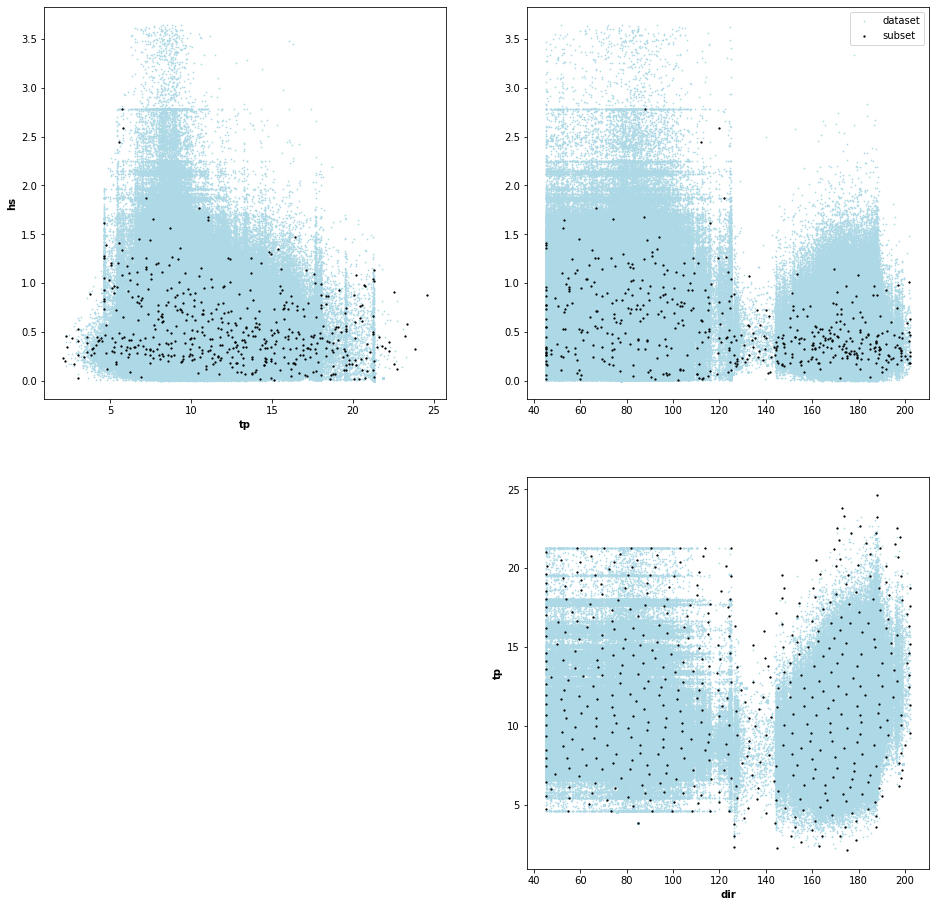

In [8]:
# --------------------------------------
# Swells
data = wvs_swl_sim[vns].values[:]

# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(data, n_subset, ix_scalar, ix_directional)
wvs_swl_sim_subset = pd.DataFrame(data=sel, columns=vns)

# add nearest hs to swells subset
ix_n = nearest_indexes(wvs_swl_sim_subset[vns].values[:], data, ix_scalar, ix_directional)
wvs_swl_sim_subset['hs'] = wvs_swl_sim['hs'].iloc[ix_n].values[:]
wvs_swl_sim_subset['n_sim'] = wvs_swl_sim['n_sim'].iloc[ix_n].values[:]

# plot results
Plot_MDA_Data(wvs_swl_sim, wvs_swl_sim_subset);

# Store MDA swell subset
wvs_swl_sim_subset = wvs_swl_sim_subset.to_xarray()
wvs_swl_sim_subset.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/EXTREMES/swells_subset.nc')
